# Alzheimer MRI Volume Classifier: Notebook Overview

This notebook demonstrates the full pipeline for classifying Alzheimer's disease from 3D MRI brain scan volumes using deep learning. The workflow includes:

1. **Data Preparation**: Grouping 2D MRI slices into 3D volumes, saving them as PyTorch tensors, and generating metadata.
2. **Dataset and DataLoader**: Custom PyTorch Dataset for loading 3D volumes and their labels, with train/validation split.
3. **Model Definition**: A small 3D CNN (Tiny3DCNN) for binary classification (Alzheimer vs. Healthy).
4. **Training**: Weighted loss to address class imbalance, early stopping, and learning rate scheduling.
5. **Evaluation**: Classification report and confusion matrix on the validation set, plus loss curve visualization.
6. **Visualization**: (See `visualize.py`) Interactive 3D MRI volume viewing with napari.

In [ ]:
# https://www.kaggle.com/datasets/ninadaithal/imagesoasis

In [ ]:
import os
import re
import pandas as pd
from collections import defaultdict

def create_dataframe(base_dir="Data"):
    pattern = re.compile(r"(OAS1_\d{4}_MR1_mpr-\d)")
    grouped = defaultdict(list)

    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path): continue

        for fname in os.listdir(class_path):
            match = pattern.match(fname)
            if match:
                key = match.group(1)
                full_path = os.path.join(class_path, fname)
                grouped[key].append((full_path, class_name))

    records = []
    for key, items in grouped.items():
        for path, label in items:
            slice_num = int(re.search(r'_(\d+)\.', path).group(1))
            records.append({"group": key, "class": label, "path": path, "slice": slice_num})

    df = pd.DataFrame(records)
    df = df.sort_values(by=["group", "slice"])
    return df
    
def remap_label(label):
    return "Healthy" if label == "Non Demented" else "Alzheimer"

In [ ]:
import os
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from multiprocessing import Pool, cpu_count
import torch
import pandas as pd

def process_group(args):
    group, group_df, save_dir = args
    label = remap_label(group_df["class"].iloc[0])
    paths = group_df.sort_values("slice")["path"].tolist()

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    volume = []
    for path in paths:
        img = Image.open(path).convert("L")
        img = transform(img)
        volume.append(img)

    volume = torch.stack(volume, dim=1)  # (1, D, H, W)
    vol_path = os.path.join(save_dir, f"{group}.pt")
    torch.save(volume, vol_path)

    return {"group": group, "class": label, "path": vol_path}


def preprocess_and_save_volumes_parallel(df, save_dir="volumes", num_workers=None):
    os.makedirs(save_dir, exist_ok=True)
    grouped = list(df.groupby("group"))

    job_args = [(group, group_df, save_dir) for group, group_df in grouped]

    if num_workers is None:
        num_workers = min(cpu_count(), 8)

    print(f"Starting multiprocessing with {num_workers} workers...")

    with Pool(num_workers) as pool:
        results = list(tqdm(pool.imap_unordered(process_group, job_args), total=len(job_args), desc="Saving volumes"))

    return pd.DataFrame(results)


In [ ]:
df = create_dataframe()
volume_df = preprocess_and_save_volumes_parallel(df)

volume_df.to_csv("volume_metadata.csv", index=False)

In [ ]:
import torch
import pandas as pd
from torch.utils.data import Dataset

class CachedVolumeDataset(Dataset):
    def __init__(self, csv_path, class_to_idx):
        self.df = pd.read_csv(csv_path)
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        volume = torch.load(row["path"])  # (1, D, H, W)
        label = self.class_to_idx[row["class"]]
        return volume, label


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models.video import r3d_18
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from tqdm import tqdm

df = pd.read_csv("volume_metadata.csv")
class_names = sorted(df["class"].unique())
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["class"], random_state=42
)

train_df.to_csv("train_volume.csv", index=False)
val_df.to_csv("val_volume.csv", index=False)

train_dataset = CachedVolumeDataset("train_volume.csv", class_to_idx)
val_dataset   = CachedVolumeDataset("val_volume.csv", class_to_idx)

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=6, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=6, num_workers=6, pin_memory=True)


In [3]:
class Tiny3DCNN(nn.Module):
    def __init__(self, in_channels=1, n_classes=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2),  # (30, 124, 248)

            nn.Conv3d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2),  # (15, 62, 124)

            nn.Conv3d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)  # → (32, 1, 1, 1)
        )
        self.fc = nn.Linear(32, n_classes)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = r3d_18(pretrained=False)
# model = mc3_18(pretrained=False)
#model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3,7,7), stride=(1,2,2), padding=(1,3,3))
#model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = Tiny3DCNN(in_channels=1, n_classes=len(class_names))
model.to(device)


Tiny3DCNN(
  (conv): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool3d(output_size=1)
  )
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
from collections import Counter
import torch
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

all_labels = []
for _, y in train_loader:
    all_labels.extend(y.numpy())

classes = np.unique(all_labels)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)

weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Class weights:", weights)

Class weights: tensor([2.1270, 0.6537], device='cuda:0')


In [ ]:
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

best_val_loss = float('inf')
patience, counter = 5, 0
train_losses, val_losses = [], []

scaler = torch.amp.GradScaler()

for epoch in range(100):
    model.train()
    train_loss = 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type=device.type):

            out = model(x)
            loss = criterion(out, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, leave=False):
            x, y = x.to(device), y.to(device)
            with torch.amp.autocast(device_type=device.type):
                out = model(x)
                loss = criterion(out, y)
            val_loss += loss.item()

            preds = torch.argmax(out, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping.")
            break


Epoch 1: Train Loss = 0.6910, Val Loss = 0.6859


Epoch 2: Train Loss = 0.6883, Val Loss = 0.6830


Epoch 3: Train Loss = 0.6864, Val Loss = 0.6823


Epoch 4: Train Loss = 0.6875, Val Loss = 0.6838


Epoch 5: Train Loss = 0.6851, Val Loss = 0.6822


Epoch 6: Train Loss = 0.6857, Val Loss = 0.6849


Epoch 7: Train Loss = 0.6853, Val Loss = 0.6824


Epoch 8: Train Loss = 0.6848, Val Loss = 0.6816


Epoch 9: Train Loss = 0.6834, Val Loss = 0.6799


Epoch 10: Train Loss = 0.6874, Val Loss = 0.6805


Epoch 11: Train Loss = 0.6841, Val Loss = 0.6806


Epoch 12: Train Loss = 0.6834, Val Loss = 0.6806


Epoch 13: Train Loss = 0.6855, Val Loss = 0.6795


Epoch 14: Train Loss = 0.6815, Val Loss = 0.6764


Epoch 15: Train Loss = 0.6811, Val Loss = 0.6763


Epoch 16: Train Loss = 0.6831, Val Loss = 0.6779


Epoch 17: Train Loss = 0.6812, Val Loss = 0.6713


Epoch 18: Train Loss = 0.6764, Val Loss = 0.6673


Epoch 19: Train Loss = 0.6768, Val Loss = 0.6562


Epoch 20: Train Loss = 0.6652, Val Loss = 0.6930


Epoch 21: Train Loss = 0.6498, Val Loss = 0.6247


Epoch 22: Train Loss = 0.6337, Val Loss = 0.5975


Epoch 23: Train Loss = 0.6192, Val Loss = 0.5813


Epoch 24: Train Loss = 0.5957, Val Loss = 0.5447


Epoch 25: Train Loss = 0.5816, Val Loss = 0.5264


Epoch 26: Train Loss = 0.5652, Val Loss = 0.5190


Epoch 27: Train Loss = 0.5775, Val Loss = 0.5316


Epoch 28: Train Loss = 0.5448, Val Loss = 0.5005


Epoch 29: Train Loss = 0.5467, Val Loss = 0.4861


Epoch 30: Train Loss = 0.5358, Val Loss = 0.4894


Epoch 31: Train Loss = 0.5281, Val Loss = 0.6494


Epoch 32: Train Loss = 0.5136, Val Loss = 0.4782


Epoch 33: Train Loss = 0.5125, Val Loss = 0.4496


Epoch 34: Train Loss = 0.5209, Val Loss = 0.5058


Epoch 35: Train Loss = 0.5116, Val Loss = 0.4601


Epoch 36: Train Loss = 0.5057, Val Loss = 0.4530


Epoch 37: Train Loss = 0.4958, Val Loss = 0.4411


Epoch 38: Train Loss = 0.4991, Val Loss = 0.4474


Epoch 39: Train Loss = 0.4973, Val Loss = 0.4563


Epoch 40: Train Loss = 0.4840, Val Loss = 0.4241


Epoch 41: Train Loss = 0.4904, Val Loss = 0.4209


Epoch 42: Train Loss = 0.4767, Val Loss = 0.4269


Epoch 43: Train Loss = 0.4869, Val Loss = 0.4539


Epoch 44: Train Loss = 0.4899, Val Loss = 0.4231


Epoch 45: Train Loss = 0.4896, Val Loss = 0.4208


Epoch 46: Train Loss = 0.4804, Val Loss = 0.4203


Epoch 47: Train Loss = 0.4825, Val Loss = 0.5302


Epoch 48: Train Loss = 0.4835, Val Loss = 0.4199


Epoch 49: Train Loss = 0.4729, Val Loss = 0.4028


Epoch 50: Train Loss = 0.4679, Val Loss = 0.4018


Epoch 51: Train Loss = 0.4662, Val Loss = 0.4063


Epoch 52: Train Loss = 0.4574, Val Loss = 0.4310


Epoch 53: Train Loss = 0.4651, Val Loss = 0.4065


Epoch 54: Train Loss = 0.4644, Val Loss = 0.3953


Epoch 55: Train Loss = 0.4559, Val Loss = 0.3902


Epoch 56: Train Loss = 0.4616, Val Loss = 0.3895


Epoch 57: Train Loss = 0.4561, Val Loss = 0.3905


Epoch 58: Train Loss = 0.4469, Val Loss = 0.3963


Epoch 59: Train Loss = 0.4435, Val Loss = 0.4317


Epoch 60: Train Loss = 0.4534, Val Loss = 0.4019


Epoch 61: Train Loss = 0.4418, Val Loss = 0.3828


Epoch 62: Train Loss = 0.4429, Val Loss = 0.3833


Epoch 63: Train Loss = 0.4397, Val Loss = 0.4168


Epoch 64: Train Loss = 0.4376, Val Loss = 0.3825


Epoch 65: Train Loss = 0.4442, Val Loss = 0.3824


Epoch 66: Train Loss = 0.4403, Val Loss = 0.3910


Epoch 67: Train Loss = 0.4421, Val Loss = 0.3867


Epoch 68: Train Loss = 0.4420, Val Loss = 0.4064


Epoch 69: Train Loss = 0.4362, Val Loss = 0.4052


Epoch 70: Train Loss = 0.4399, Val Loss = 0.3796


Epoch 71: Train Loss = 0.4266, Val Loss = 0.3823


Epoch 72: Train Loss = 0.4395, Val Loss = 0.3866


Epoch 73: Train Loss = 0.4349, Val Loss = 0.3773


Epoch 74: Train Loss = 0.4330, Val Loss = 0.3776


Epoch 75: Train Loss = 0.4295, Val Loss = 0.3785


Epoch 76: Train Loss = 0.4370, Val Loss = 0.3784


Epoch 77: Train Loss = 0.4297, Val Loss = 0.3793


Epoch 78: Train Loss = 0.4223, Val Loss = 0.3930
Early stopping.


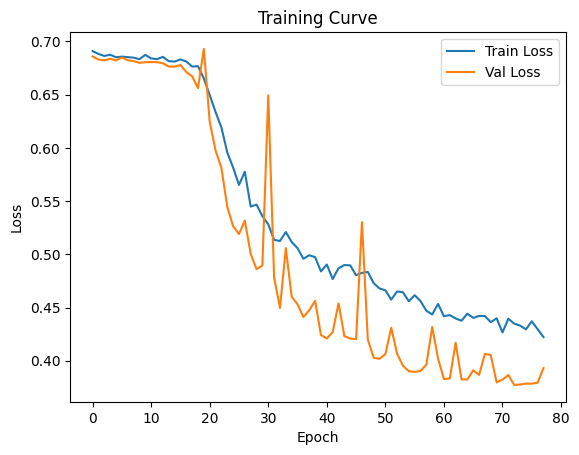

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()


              precision    recall  f1-score   support

   Alzheimer       0.62      0.89      0.73        63
     Healthy       0.96      0.83      0.89       206

    accuracy                           0.84       269
   macro avg       0.79      0.86      0.81       269
weighted avg       0.88      0.84      0.85       269



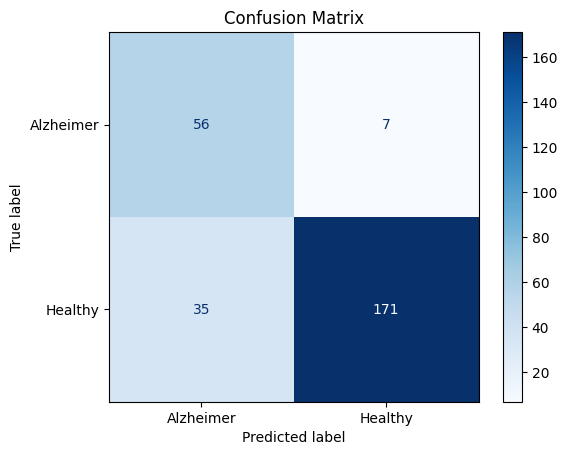

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        out = model(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()